# Vector data analysis

In the second demo of this week, we will introduce the basics of vector data analysis in Python with an example. We have two shapefiles. The first shapefile contains the name, location, and capacity of all major sports stadiums in the United States as **points**. The second shapefile contains the states on the United States as **polygons**. An alien would like to know which state contains the highest number of stadiums, the highest number of seats, and the closest and furthest stadiums from University of Oregon's campus. 

In [248]:
import geopandas as gpd

# Import data
stadiums = gpd.read_file('data/sports_venues.shp')
states = gpd.read_file('data/us_states.shp')

In [249]:
stadiums

,NAME,CAPACITY,geometry
0,MILWAUKEE MILE,45000.0,POINT (-9797298.508 5315043.944)
1,STREETS OF ST. PETERSBURG,-999.0,POINT (-9198320.620 3219439.478)
2,STREETS OF LONG BEACH,-999.0,POINT (-13157142.784 3997054.057)
3,BARBER MOTORSPORTS PARK,-999.0,POINT (-9642382.973 3966132.844)
4,STREETS OF TORONTO,-999.0,POINT (-8840529.757 5408873.389)
...,...,...,...
819,UPMC EVENTS CENTER,4000.0,POINT (-8929463.890 4941833.552)
820,GLOBE LIFE FIELD,40000.0,POINT (-10807587.284 3861421.677)
821,WEATHERTECH RACEWAY LAGUNA SECA,11000.0,POINT (-13553512.291 4381243.369)
822,CIRCUIT OF THE AMERICAS,120000.0,POINT (-10868589.591 3520977.940)


## Explore

It is always good practice to start with a visualization to check everything is projected properly.

In [250]:
stadiums.explore()

In [251]:
stadiums.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      824 non-null    object  
 1   CAPACITY  824 non-null    float64 
 2   geometry  824 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 19.4+ KB


The `info()` method reveals that there are no missing values... or are there?

In [252]:
stadiums.describe()

,CAPACITY
count,824.000000
mean,20984.593447
std,26260.948903
min,-999.000000
25%,4584.500000
50%,10333.500000
75%,26436.000000
max,257325.000000


## Remove missing values

When we run `describe()` we notice that the **min** value is `-999` which is a value often used to indicate **no data**. Since we have no logical way of interpolating those values, we will just remove these rows. We can do this by filtring our DataFrame with a **mask** that returns `True` if values are **not equal** to `-999`.

In [253]:
stadiums = stadiums[stadiums['CAPACITY'] != -999]
stadiums.describe()

,CAPACITY
count,722.000000
mean,24090.308864
std,26630.288096
min,837.000000
25%,6500.000000
50%,13073.000000
75%,31875.000000
max,257325.000000


## Check projections

If we are going to find how many stadiums are in each state, we will need to join the DataFrames. But we can only do this if they are in the same projection.

In [254]:
stadiums.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [255]:
states.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Since they are in different projections, we will convert the `stadiums` DataFrame to match the `states` DataFrame.

In [256]:
stadiums = stadiums.to_crs('EPSG:5070')
stadiums.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Join DataFrames

A spatial join ([`sjoin`](https://geopandas.org/en/stable/gallery/spatial_joins.html)) can be used to combine two `GeoDataFrames` based on the spatial relationship between their geometries. A common use case might be a spatial join between a point layer (stadiums) and a polygon layer (states) so that we we retain the point geometries and add the attributes of the intersecting polygons. 

Now we know from exploring the data that there are some stadiums that are outside the US. We would like to exclude those from our analysis. An **inner join** (`how='inner'`), keeps rows from both `GeoDataFrames` **only** when the points are contained within the polygons.

In [257]:
stadiums_usa = stadiums.sjoin(states, how='inner')

Now when we plot our data again, we find that there are no stadiums outside the USA and that the points have more attributes, including the **state** that they are within. 

````{margin}
```{note}
Also notice that since the attribute `NAME` was in both datasets, `GeoPandas` automatically appends `_right` and `_left` to distinguish them.
```
````


In [258]:
stadiums_usa.explore()

## Compute stats

We can complete our first task by grouping the stadiums by state, summing their capacities, and sorting from highest to lowest. 

In [259]:
stadiums_usa.groupby('NAME_right')['CAPACITY'].sum().sort_values(ascending=False).head()

NAME_right
Texas         1493214.0
California    1383573.0
Florida        987111.0
Indiana        675805.0
Ohio           641793.0
Name: CAPACITY, dtype: float64

```{note}
Calling more than one method on an object is called **method chaining**.
```


In [260]:
top_state = stadiums_usa.groupby('NAME_right')['CAPACITY'].sum().sort_values(ascending=False).index[0]
top_seats = stadiums_usa.groupby('NAME_right')['CAPACITY'].sum().sort_values(ascending=False).iloc[0]

f"{top_state} has the most stadium seats in the US with {int(top_seats)}"


'Texas has the most stadium seats in the US with 1493214'

If we wanted to find the state with the most stadiums we could can just change `sum()` to `count()`.

In [261]:
stadiums_usa.groupby('NAME_right')['CAPACITY'].count().sort_values(ascending=False).head()

NAME_right
California        58
Texas             52
New York          39
Florida           33
North Carolina    30
Name: CAPACITY, dtype: int64

In [262]:
top_state = stadiums_usa.groupby('NAME_right')['CAPACITY'].count().sort_values(ascending=False).index[0]
top_stadiums = stadiums_usa.groupby('NAME_right')['CAPACITY'].count().sort_values(ascending=False).iloc[0]

f"{top_state} has the most sports stadiums in the US with {int(top_stadiums)}"

'California has the most sports stadiums in the US with 58'

## Measure distance

Our final task is to compute the distance between University of Oregon campus and all the stadiums in the dataset. 

```{caution}
When computing distance or area, we must make sure that our data have a projected CRS (in meters, feet, kilometers etc.) not a geographic one (in degrees). `GeoPandas` operations are planar, whereas degrees reflect the position on a sphere. Therefore, spatial operations using degrees may not yield correct results.
```

We are OK to compute distances using our stadium data because when we call the `crs` method, we can see that the Easting and Northing are in the **meters**. 

In [263]:
stadiums_usa.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

We will first create a `GeoDataFrame` with a single row that represents the longitude and latitude of campus (-123.0783, 44.04505) as a `Point` data type. 

In [264]:
from shapely.geometry import Point

data = {'geometry': [Point(-123.0783, 44.04505)]}

s = gpd.GeoDataFrame(data, crs="EPSG:4326")
s

,geometry
0,POINT (-123.07830 44.04505)


Next we must convert this `GeoDataFrame` to the same projection as our stadium data (`EPSG:5070`).

In [265]:
s.to_crs('EPSG:5070', inplace=True)
s

,geometry
0,POINT (-2133399.001 2645357.154)


Now we can compute distances to all stadiums in the United States using the [`distance()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html) method.

In [266]:
distance = stadiums_usa.distance(s['geometry'].iloc[0])
distance 

0      2.807969e+06
46     2.771818e+06
155    2.695892e+06
189    2.810889e+06
274    2.790744e+06
           ...     
483    2.072308e+06
648    2.056440e+06
484    2.089632e+06
658    2.105634e+06
776    2.105656e+06
Length: 696, dtype: float64

Let's add this new data as a column to our original `GeoDataFrame` and convert to kilometers.

In [267]:
stadiums_usa['distance_to_eugene'] = distance / 1000
stadiums_usa

,NAME_left,CAPACITY,geometry,index_right,STATEFP,STUSPS,NAME_right,distance_to_eugene
0,MILWAUKEE MILE,45000.0,POINT (646905.219 2252165.087),14,55,WI,Wisconsin,2807.969295
46,LAMBEAU FIELD,81441.0,POINT (628952.471 2416474.808),14,55,WI,Wisconsin,2771.817595
155,CAMP RANDALL STADIUM,80321.0,POINT (533197.371 2249000.861),14,55,WI,Wisconsin,2695.892157
189,MILLER PARK,41900.0,POINT (650017.078 2253318.084),14,55,WI,Wisconsin,2810.889486
274,ROAD AMERICA,40000.0,POINT (640442.284 2338673.449),14,55,WI,Wisconsin,2790.743695
...,...,...,...,...,...,...,...,...
483,SCHEELS CENTER,5830.0,POINT (-61123.759 2656923.016),37,38,ND,North Dakota,2072.307518
648,BETTY ENGELSTAD SIOUX CENTER,3300.0,POINT (-80779.004 2770637.937),37,38,ND,North Dakota,2056.439673
484,FROST ARENA,6500.0,POINT (-61986.213 2370021.948),41,46,SD,South Dakota,2089.631646
658,DAKOTADOME,10000.0,POINT (-75459.148 2199735.337),41,46,SD,South Dakota,2105.634167


## Make a map

We can plot the stadium data again but this time using time color the dots based on distance to campus. See [here](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html) for more examples of interactive plotting and [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for a full list of colormaps.

In [268]:
stadiums_usa.explore(column='distance_to_eugene', cmap='Set1')

```{note}
The `explore()` method returns a `folium.Map` object which is a really nice way of making interactive maps. We don't have enough time to cover `Folium` in this course. But we use it a lot in **Geospatial Data Science**, the next course in this series. 
```

## Chloropleth maps

Choropleth maps, where the color of each shape is based on the value of an associated variable, are a useful for displaying geospatial data. If we wanted to produce a chloropleth map showing the number of stadiums in each state, we would first group the stadium data by state.

In [320]:
stadiums_by_state = stadiums_usa.groupby('NAME_right')['CAPACITY'].count().reset_index()
stadiums_by_state.head()

,NAME_right,CAPACITY
0,Alabama,16
1,Arizona,11
2,Arkansas,9
3,California,58
4,Colorado,13


Then we would join this new dataframe with the original `GeoDataFrame` of US states so we can add the `geometry` data. This time we are joining based on a **primary key** which has to be specified using the `left_on` and `right_on` keyword arguments.

In [323]:
states_merge = states.merge(stadiums_by_state, left_on='NAME', right_on='NAME_right')
states_merge.head()

,STATEFP,STUSPS,NAME,geometry,NAME_right,CAPACITY
0,24,MD,Maryland,"MULTIPOLYGON (((1722285.499 1847164.899, 17253...",Maryland,16
1,19,IA,Iowa,"POLYGON ((-50588.826 2198204.224, -46981.682 2...",Iowa,8
2,10,DE,Delaware,"POLYGON ((1705277.992 2038007.044, 1706136.968...",Delaware,3
3,39,OH,Ohio,"MULTIPOLYGON (((1081987.294 2151544.264, 10846...",Ohio,30
4,42,PA,Pennsylvania,"POLYGON ((1287711.752 2093650.229, 1286266.040...",Pennsylvania,25


Now we can make our chloropleth map but first let's compute another variable: **stadium density**.

In [347]:
states_merge['area'] = states_merge.area / 1000000000000
states_merge['stadium_density'] = states_merge['CAPACITY'] / states_merge['area'] 

<AxesSubplot:>

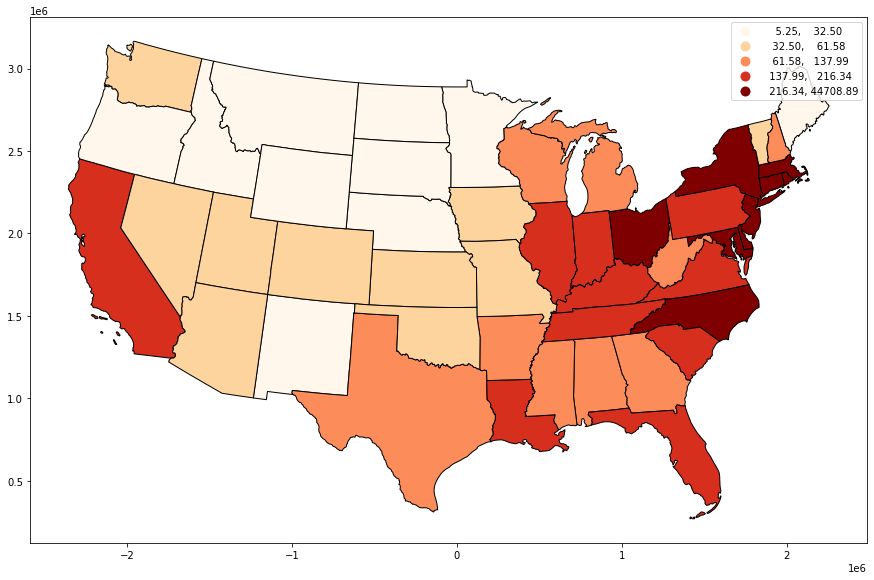

In [362]:
states_merge.plot(
    column="stadium_density",
    cmap='OrRd',
    legend=True,
    scheme="quantiles",
    edgecolor='black',
    figsize=(15, 10))